In [ ]:
#ideal version for this code is tensorflow 2.6.0

!pip install pmdarima
#pip install keras==2.6.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 37.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as ts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Bidirectional, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error
%matplotlib inline
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

In [ ]:
data_ts = pd.read_csv("/content/drive/MyDrive/time_series_60min_singleindex.csv", parse_dates=['utc_timestamp'])
data_ts["utc_timestamp"] = pd.to_datetime(data_ts["utc_timestamp"])
data_ts

,utc_timestamp,cet_cest_timestamp,AT_load_actual_entsoe_transparency,AT_load_forecast_entsoe_transparency,AT_price_day_ahead,AT_solar_generation_actual,AT_wind_onshore_generation_actual,BE_load_actual_entsoe_transparency,BE_load_forecast_entsoe_transparency,BE_solar_generation_actual,...,SI_load_actual_entsoe_transparency,SI_load_forecast_entsoe_transparency,SI_solar_generation_actual,SI_wind_onshore_generation_actual,SK_load_actual_entsoe_transparency,SK_load_forecast_entsoe_transparency,SK_solar_generation_actual,SK_wind_onshore_generation_actual,UA_load_actual_entsoe_transparency,UA_load_forecast_entsoe_transparency
0,2014-12-31 23:00:00+00:00,2015-01-01T00:00:00+0100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 00:00:00+00:00,2015-01-01T01:00:00+0100,5946.0,6701.0,35.0,NaN,69.0,9484.0,9897.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 01:00:00+00:00,2015-01-01T02:00:00+0100,5726.0,6593.0,45.0,NaN,64.0,9152.0,9521.0,NaN,...,1045.47,816.0,NaN,1.17,2728.0,2860.0,3.8,NaN,NaN,NaN
3,2015-01-01 02:00:00+00:00,2015-01-01T03:00:00+0100,5347.0,6482.0,41.0,NaN,65.0,8799.0,9135.0,NaN,...,1004.79,805.0,NaN,1.04,2626.0,2810.0,3.8,NaN,NaN,NaN
4,2015-01-01 03:00:00+00:00,2015-01-01T04:00:00+0100,5249.0,6454.0,38.0,NaN,64.0,8567.0,8909.0,NaN,...,983.79,803.0,NaN,1.61,2618.0,2780.0,3.8,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50396,2020-09-30 19:00:00+00:00,2020-09-30T21:00:00+0200,6661.0,6656.0,NaN,NaN,1847.0,9402.0,9720.0,NaN,...,1506.95,1530.0,5.32,0.44,3324.0,3170.0,1.7,1.1,NaN,NaN
50397,2020-09-30 20:00:00+00:00,2020-09-30T22:00:00+0200,6336.0,6310.0,NaN,NaN,1723.0,9219.0,9418.0,NaN,...,1391.15,1388.0,5.57,0.62,3099.0,3010.0,1.7,1.0,NaN,NaN
50398,2020-09-30 21:00:00+00:00,2020-09-30T23:00:00+0200,5932.0,5813.0,NaN,NaN,1771.0,8763.0,8873.0,NaN,...,1250.17,1274.0,5.58,0.66,2940.0,2890.0,1.6,1.0,NaN,NaN
50399,2020-09-30 22:00:00+00:00,2020-10-01T00:00:00+0200,5628.0,5424.0,NaN,NaN,1779.0,8131.0,8285.0,NaN,...,1206.82,1178.0,5.61,0.21,2823.0,2740.0,1.7,1.2,NaN,NaN


In [ ]:
data_w = pd.read_csv("/content/drive/MyDrive/weather_data.csv", parse_dates=['utc_timestamp'])
data_w["utc_timestamp"] = pd.to_datetime(data_w["utc_timestamp"])
data_w

,utc_timestamp,AT_temperature,AT_radiation_direct_horizontal,AT_radiation_diffuse_horizontal,BE_temperature,BE_radiation_direct_horizontal,BE_radiation_diffuse_horizontal,BG_temperature,BG_radiation_direct_horizontal,BG_radiation_diffuse_horizontal,...,RO_radiation_diffuse_horizontal,SE_temperature,SE_radiation_direct_horizontal,SE_radiation_diffuse_horizontal,SI_temperature,SI_radiation_direct_horizontal,SI_radiation_diffuse_horizontal,SK_temperature,SK_radiation_direct_horizontal,SK_radiation_diffuse_horizontal
0,1980-01-01 00:00:00+00:00,-3.640,0.0,0.0,-0.720,0.0,0.0,4.664,0.0,0.0,...,0.0,-3.945,0.0,0.0,-3.055,0.0,0.0,-4.648,0.0,0.0
1,1980-01-01 01:00:00+00:00,-3.803,0.0,0.0,-1.165,0.0,0.0,4.052,0.0,0.0,...,0.0,-4.053,0.0,0.0,-3.272,0.0,0.0,-4.554,0.0,0.0
2,1980-01-01 02:00:00+00:00,-3.969,0.0,0.0,-1.434,0.0,0.0,3.581,0.0,0.0,...,0.0,-4.129,0.0,0.0,-3.639,0.0,0.0,-4.455,0.0,0.0
3,1980-01-01 03:00:00+00:00,-4.076,0.0,0.0,-1.843,0.0,0.0,3.197,0.0,0.0,...,0.0,-4.139,0.0,0.0,-4.202,0.0,0.0,-4.421,0.0,0.0
4,1980-01-01 04:00:00+00:00,-4.248,0.0,0.0,-2.094,0.0,0.0,2.750,0.0,0.0,...,0.0,-4.239,0.0,0.0,-4.732,0.0,0.0,-4.449,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350635,2019-12-31 19:00:00+00:00,-1.386,0.0,0.0,1.684,0.0,0.0,-1.351,0.0,0.0,...,0.0,-0.382,0.0,0.0,0.053,0.0,0.0,-0.766,0.0,0.0
350636,2019-12-31 20:00:00+00:00,-1.661,0.0,0.0,1.718,0.0,0.0,-1.009,0.0,0.0,...,0.0,-0.418,0.0,0.0,-0.207,0.0,0.0,-0.742,0.0,0.0
350637,2019-12-31 21:00:00+00:00,-1.986,0.0,0.0,1.726,0.0,0.0,-0.986,0.0,0.0,...,0.0,-0.490,0.0,0.0,-0.203,0.0,0.0,-0.764,0.0,0.0
350638,2019-12-31 22:00:00+00:00,-2.184,0.0,0.0,1.569,0.0,0.0,-1.270,0.0,0.0,...,0.0,-0.434,0.0,0.0,-0.032,0.0,0.0,-0.867,0.0,0.0


Resample dataset to be daily instead of hourly because the dataset is too noisy

In [ ]:
vars = ["utc_timestamp", 'DE_wind_capacity',"DE_wind_generation_actual", "DE_wind_offshore_capacity", "DE_wind_offshore_generation_actual","DE_wind_onshore_capacity","DE_wind_onshore_generation_actual"]

In [ ]:
vars2 = ['utc_timestamp','DE_temperature']

In [ ]:
data_ts2 = data_ts[vars]
data_w2 = data_w[vars2]

In [ ]:
data_ts3 = data_ts2.resample('24H', on = 'utc_timestamp').agg({"DE_wind_generation_actual":np.sum,
                                                       'DE_wind_capacity': np.mean,
                                                       "DE_wind_offshore_capacity":np.mean,
                                                       "DE_wind_offshore_generation_actual":np.sum,
                                                       "DE_wind_onshore_capacity":np.mean,
                                                       "DE_wind_onshore_generation_actual":np.sum
                                                       })

#data_ts3["utc_timestamp"] = data_ts3.index
data_ts3 = data_ts3.reset_index()
#data_ts3  = data_ts3.drop(['utc_timestamp'], axis = 1)

In [ ]:
data_w3 = data_w2.resample('24H', on = 'utc_timestamp').agg({"DE_temperature":np.mean})
data_w3 = data_w3.reset_index()
#data_w3["utc_timestamp"] = data_w3.index
#data_w3  = data_w3.drop(['utc_timestamp'], axis = 1)

In [ ]:
data = pd.merge(data_ts3,data_w3, on = "utc_timestamp")
cols = []
for col in data.columns:
  if col != "utc_timestamp":
    cols.append(col[3:])
  else:
    cols.append("utc_timestamp")
data.columns = cols
data

,utc_timestamp,wind_generation_actual,wind_capacity,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual,temperature
0,2014-12-31 00:00:00+00:00,0.0,27913.000000,667.000000,0.0,27246.000000,0.0,-0.057542
1,2015-01-01 00:00:00+00:00,325165.0,27913.541667,667.000000,12297.0,27246.541667,312868.0,-0.295958
2,2015-01-02 00:00:00+00:00,603554.0,27926.000000,667.000000,10533.0,27259.000000,593022.0,1.619958
3,2015-01-03 00:00:00+00:00,462955.0,27926.000000,667.000000,12125.0,27259.000000,450829.0,0.851458
4,2015-01-04 00:00:00+00:00,385023.0,27926.541667,667.125000,11500.0,27259.375000,373525.0,0.493625
...,...,...,...,...,...,...,...,...
1822,2019-12-27 00:00:00+00:00,146590.0,50427.000000,5735.000000,40135.0,44692.000000,106453.0,1.327167
1823,2019-12-28 00:00:00+00:00,159126.0,50427.291667,5735.291667,66626.0,44692.000000,92505.0,-1.441167
1824,2019-12-29 00:00:00+00:00,349839.0,50434.750000,5742.000000,121886.0,44692.750000,227954.0,-1.314500
1825,2019-12-30 00:00:00+00:00,669271.0,50452.000000,5742.000000,133426.0,44710.000000,535847.0,0.510208


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1827 entries, 0 to 1826
Data columns (total 8 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   utc_timestamp                    1827 non-null   datetime64[ns, UTC]
 1   wind_generation_actual           1827 non-null   float64            
 2   wind_capacity                    1826 non-null   float64            
 3   wind_offshore_capacity           1826 non-null   float64            
 4   wind_offshore_generation_actual  1827 non-null   float64            
 5   wind_onshore_capacity            1826 non-null   float64            
 6   wind_onshore_generation_actual   1827 non-null   float64            
 7   temperature                      1827 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(7)
memory usage: 128.5 KB


we have missing data

In [ ]:
data.isnull().sum()*100 / data.shape[0]

utc_timestamp                      0.000000
wind_generation_actual             0.000000
wind_capacity                      0.054735
wind_offshore_capacity             0.054735
wind_offshore_generation_actual    0.000000
wind_onshore_capacity              0.054735
wind_onshore_generation_actual     0.000000
temperature                        0.000000
dtype: float64

In [ ]:
data.isna().sum()

utc_timestamp                      0
wind_generation_actual             0
wind_capacity                      1
wind_offshore_capacity             1
wind_offshore_generation_actual    0
wind_onshore_capacity              1
wind_onshore_generation_actual     0
temperature                        0
dtype: int64

In [ ]:
data = data.fillna(0)
data.isna().sum()

utc_timestamp                      0
wind_generation_actual             0
wind_capacity                      0
wind_offshore_capacity             0
wind_offshore_generation_actual    0
wind_onshore_capacity              0
wind_onshore_generation_actual     0
temperature                        0
dtype: int64

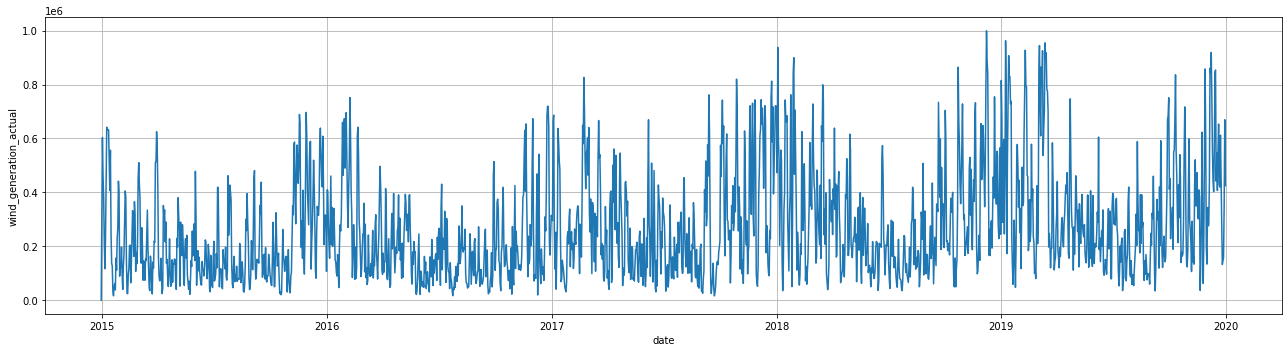

In [ ]:
fig, ax = plt.subplots(figsize=(18, 5))
#one_year = data[(data["utc_timestamp"] > '2018-12-30 22:00:00+00:00') & (data["utc_timestamp"] <= '2019-12-30 22:00:00+00:00')]
ax.plot( (data["utc_timestamp"]), data["wind_generation_actual"])
ax.grid()
ax.set_ylabel("wind_generation_actual")
ax.set_xlabel('date')
fig.tight_layout()
plt.show()

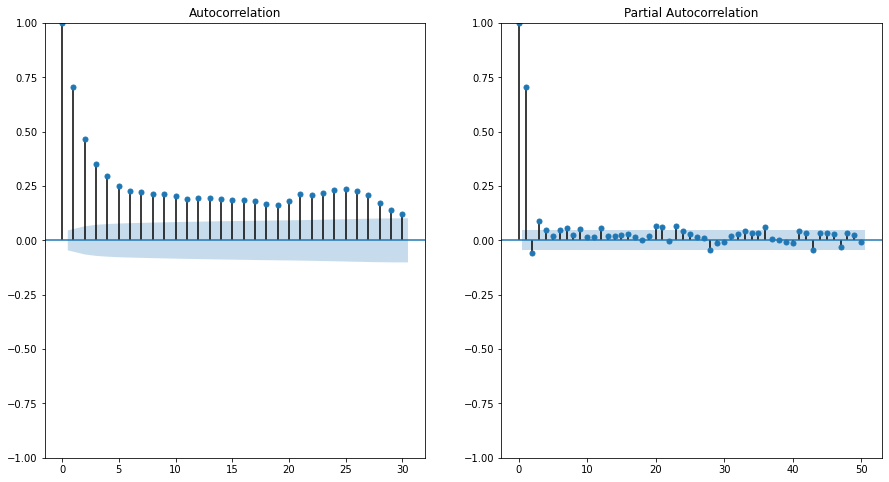

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
acf_plot = plot_acf(data['wind_generation_actual'], lags=30, ax = ax[0])
pacf_plot = plot_pacf(data["wind_generation_actual"], lags=50, ax = ax[1])
plt.show()

plots: determine the ARIMAX(p,d,q) model parameters where p is determined by acf plot and q is determined by partial acf plot and also help in feature engineering

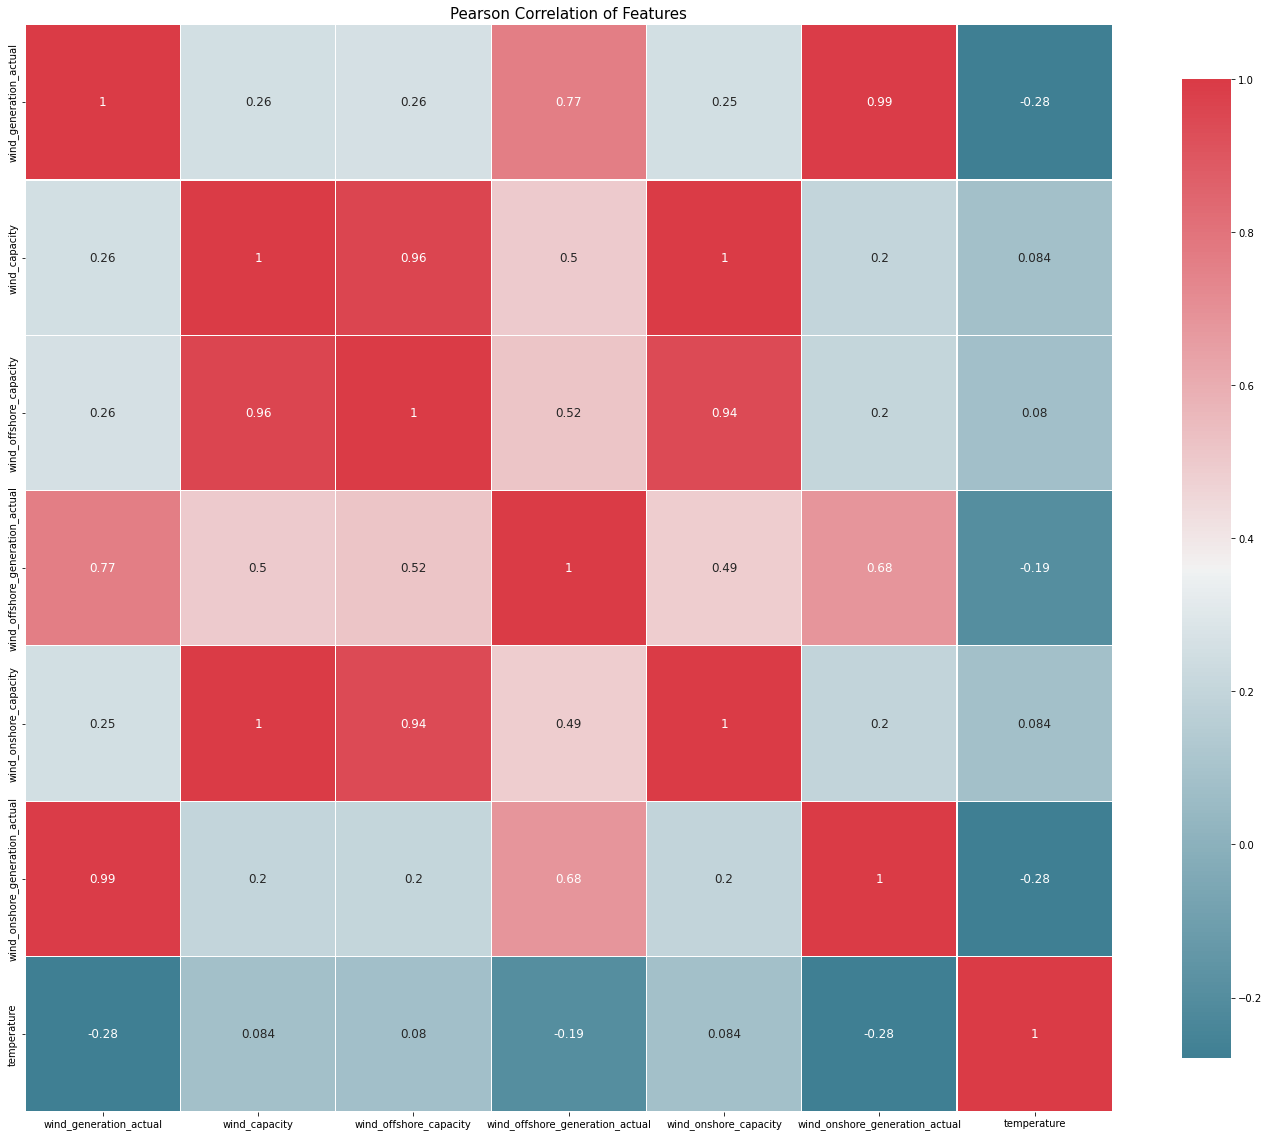

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(25, 20))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)

# Feature engineering
+https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114


create new features such as year or month and shifted versions of original features (lag features)
+https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/#:~:text=the%20next%20section.-,Lag%20Features,transformed%20into%20supervised%20learning%20problems.&text=The%20Pandas%20library%20provides%20the,from%20a%20time%20series%20dataset.
Lag features are the classical way that time series forecasting problems are transformed into supervised learning problems. The Pandas library provides the shift() function to help create these shifted or lag features from a time series dataset.

In [ ]:
def feature_engineering(data):

    data["utc_timestamp"] = pd.to_datetime(data["utc_timestamp"], format="%Y-%m-%d")
    data["year"] = data["utc_timestamp"].dt.year
    data["month"] = data["utc_timestamp"].dt.month

    lag_features = ["wind_generation_actual"]
    window1 = 2
    window2 = 3
    window3 = 7

    data_rolled_2d = data[lag_features].rolling(window=window1, min_periods=0)
    data_rolled_3d = data[lag_features].rolling(window=window2, min_periods=0)
    data_rolled_7d = data[lag_features].rolling(window=window3, min_periods=0)

    #mean  of all
    data_mean_2d = data_rolled_2d.mean().shift(1)
    data_mean_3d = data_rolled_3d.mean().shift(1)
    data_mean_7d = data_rolled_7d.mean().shift(1)

    #std of all
    data_std_2d = data_rolled_2d.std().shift(1)
    data_std_3d = data_rolled_3d.std().shift(1)
    data_std_7d = data_rolled_7d.std().shift(1)


    #loop for implimentation
    for feature in lag_features:
        data[f"{feature}_mean_lag{window1}"] = data_mean_2d[feature]
        data[f"{feature}_mean_lag{window2}"] = data_mean_3d[feature]
        data[f"{feature}_mean_lag{window3}"] = data_mean_7d[feature]

        data[f"{feature}_std_lag{window1}"] = data_std_2d[feature]
        data[f"{feature}_std_lag{window2}"] = data_std_3d[feature]
        data[f"{feature}_std_lag{window3}"] = data_std_7d[feature]

    data.fillna(data.mean(), inplace=True)

feature_engineering(data)

In [ ]:
data

,utc_timestamp,wind_generation_actual,wind_capacity,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual,temperature,year,month,wind_generation_actual_mean_lag2,wind_generation_actual_mean_lag3,wind_generation_actual_mean_lag7,wind_generation_actual_std_lag2,wind_generation_actual_std_lag3,wind_generation_actual_std_lag7
0,2014-12-31 00:00:00+00:00,0.0,27913.000000,667.000000,0.0,27246.000000,0.0,-0.057542,2014,12,266913.023823,266817.753286,266841.053197,77939.006866,97082.475266,127267.548419
1,2015-01-01 00:00:00+00:00,325165.0,27913.541667,667.000000,12297.0,27246.541667,312868.0,-0.295958,2015,1,0.000000,0.000000,0.000000,77939.006866,97082.475266,127267.548419
2,2015-01-02 00:00:00+00:00,603554.0,27926.000000,667.000000,10533.0,27259.000000,593022.0,1.619958,2015,1,162582.500000,162582.500000,162582.500000,229926.376505,229926.376505,229926.376505
3,2015-01-03 00:00:00+00:00,462955.0,27926.000000,667.000000,12125.0,27259.000000,450829.0,0.851458,2015,1,464359.500000,309573.000000,309573.000000,196850.749708,302078.947590,302078.947590
4,2015-01-04 00:00:00+00:00,385023.0,27926.541667,667.125000,11500.0,27259.375000,373525.0,0.493625,2015,1,533254.500000,463891.333333,347918.500000,99418.506328,139196.861927,258294.347336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2019-12-27 00:00:00+00:00,146590.0,50427.000000,5735.000000,40135.0,44692.000000,106453.0,1.327167,2019,12,213194.000000,293860.000000,428006.714286,113780.552161,161226.603552,178293.300669
1823,2019-12-28 00:00:00+00:00,159126.0,50427.291667,5735.291667,66626.0,44692.000000,92505.0,-1.441167,2019,12,139664.500000,190992.666667,355604.571429,9794.136026,89172.331081,174369.098096
1824,2019-12-29 00:00:00+00:00,349839.0,50434.750000,5742.000000,121886.0,44692.750000,227954.0,-1.314500,2019,12,152858.000000,146151.666667,317021.571429,8864.290609,13198.959972,184929.477793
1825,2019-12-30 00:00:00+00:00,669271.0,50452.000000,5742.000000,133426.0,44710.000000,535847.0,0.510208,2019,12,254482.500000,218518.333333,307030.857143,134854.455560,113899.631011,180283.892782


In [ ]:
data.isnull().sum()

utc_timestamp                       0
wind_generation_actual              0
wind_capacity                       0
wind_offshore_capacity              0
wind_offshore_generation_actual     0
wind_onshore_capacity               0
wind_onshore_generation_actual      0
temperature                         0
year                                0
month                               0
wind_generation_actual_mean_lag2    0
wind_generation_actual_mean_lag3    0
wind_generation_actual_mean_lag7    0
wind_generation_actual_std_lag2     0
wind_generation_actual_std_lag3     0
wind_generation_actual_std_lag7     0
dtype: int64

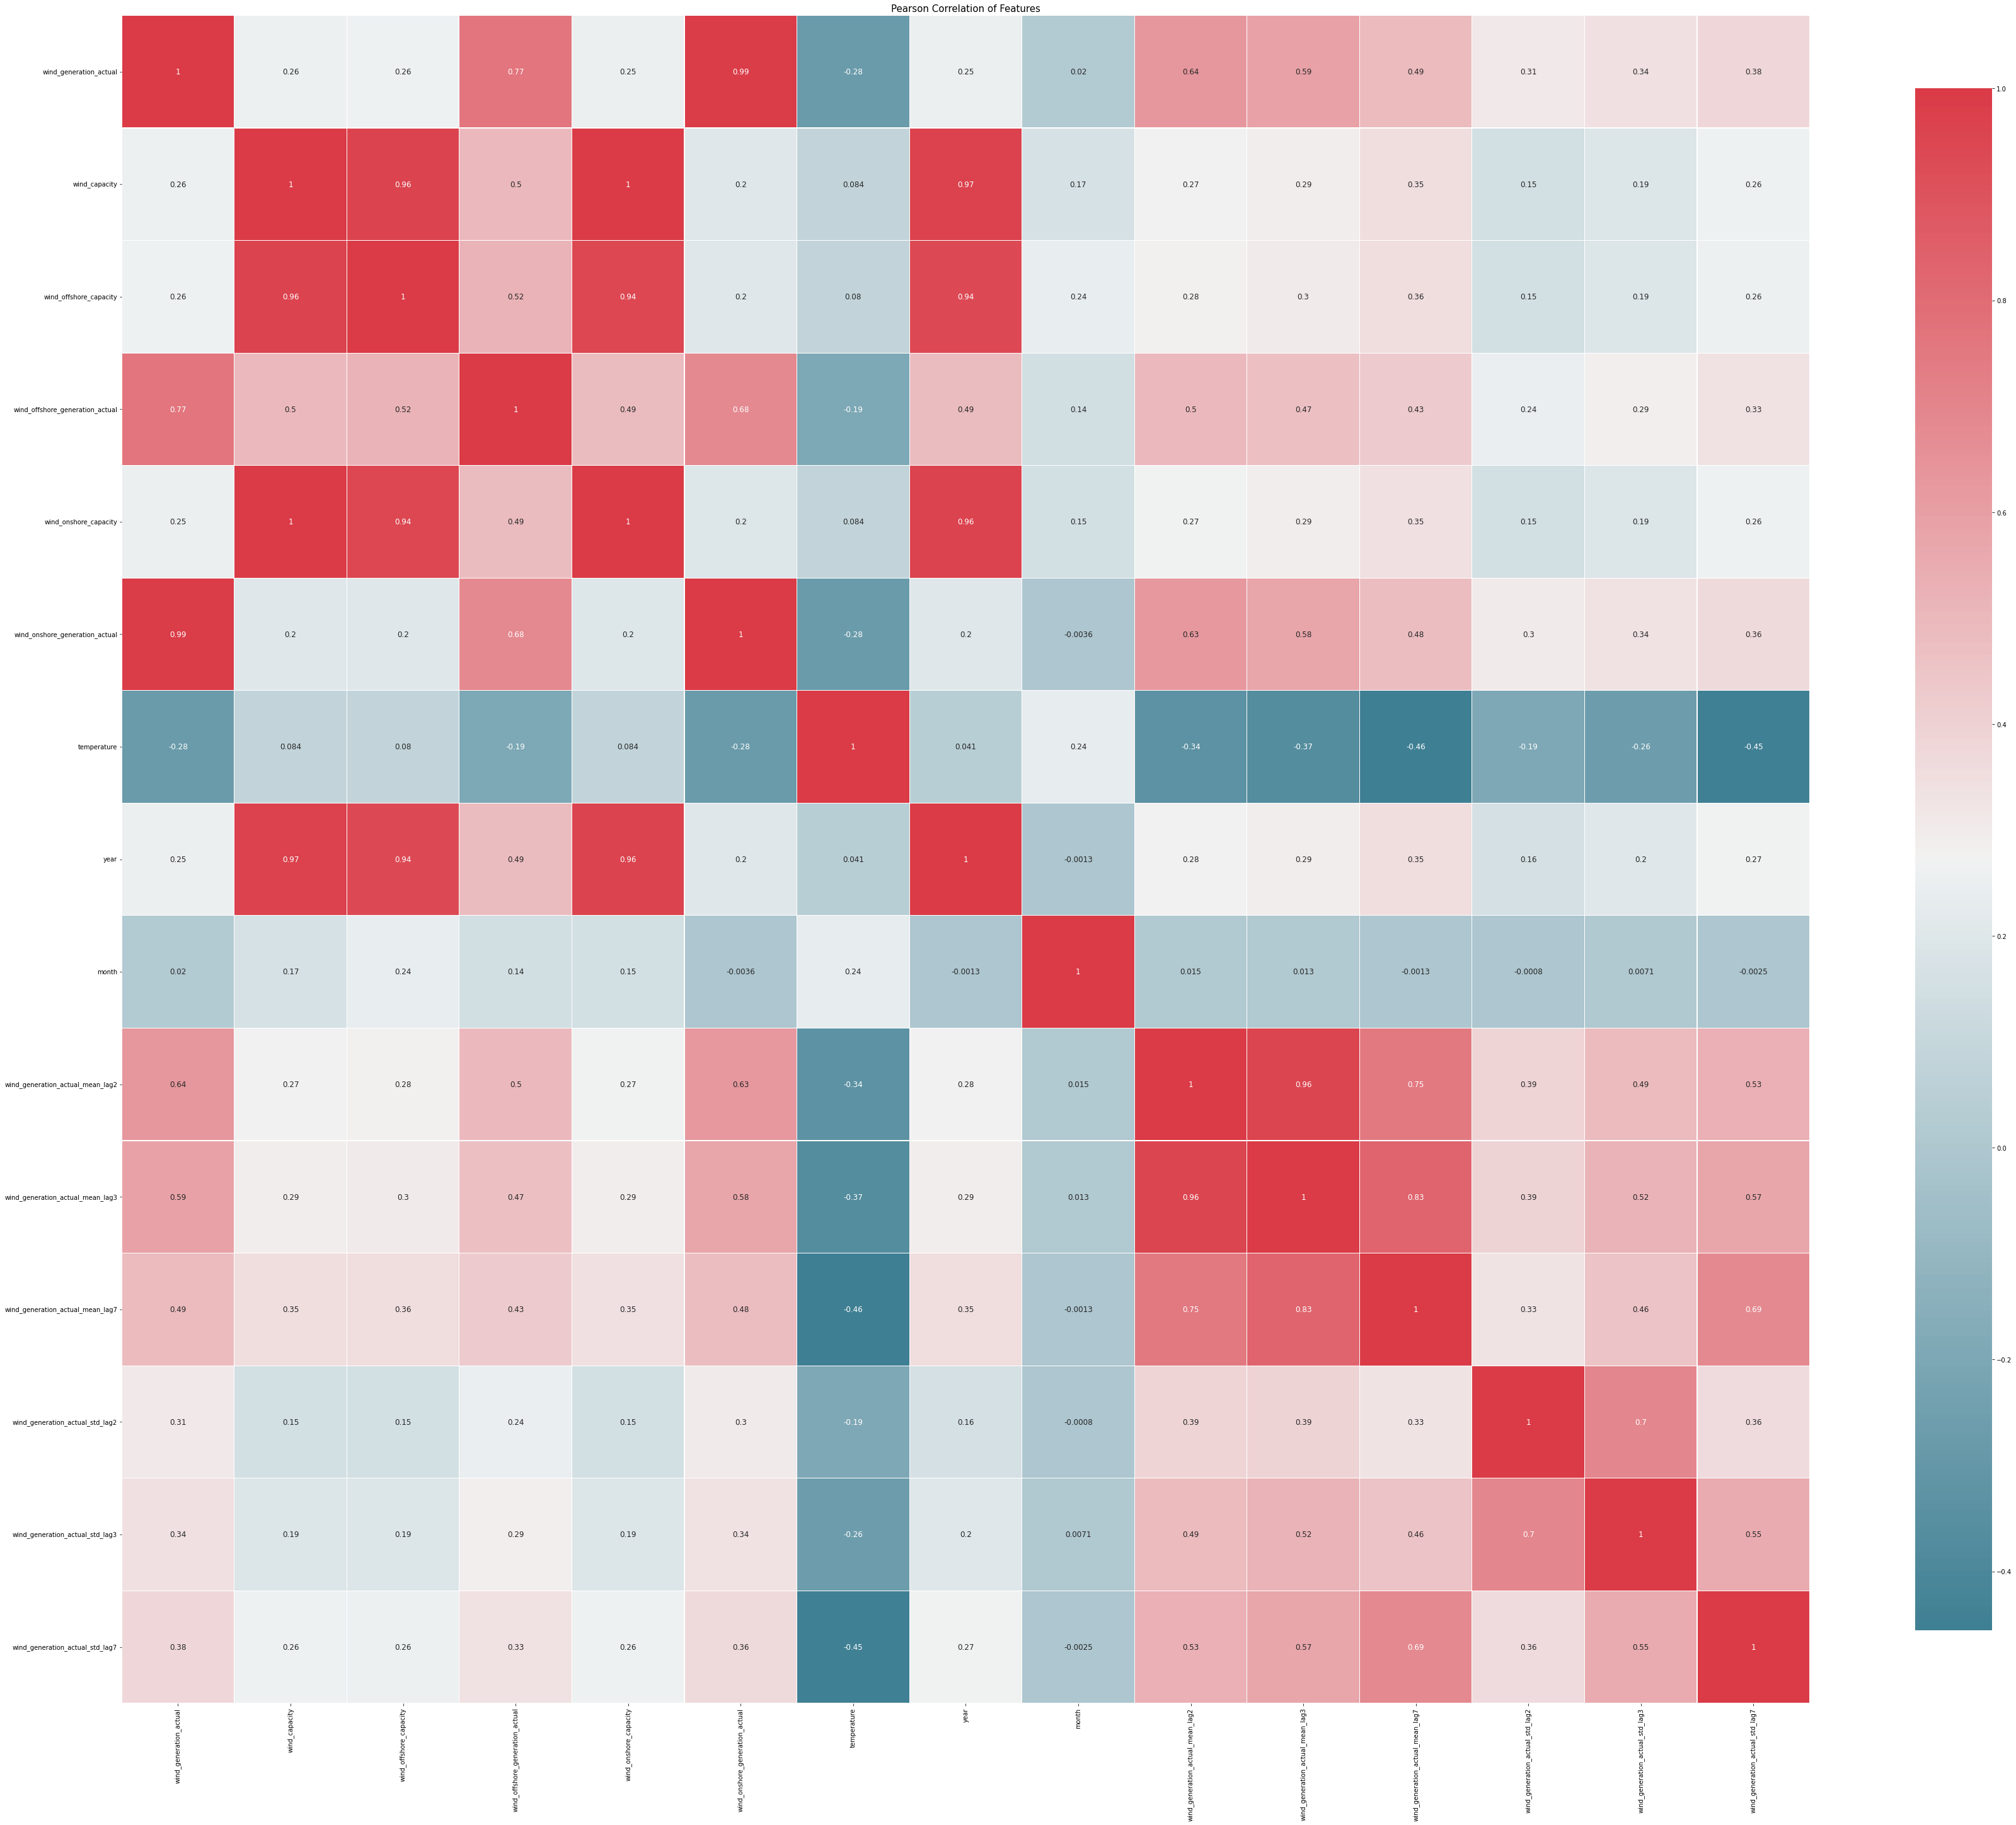

In [ ]:
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(60, 50))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data)


In [ ]:
data

,utc_timestamp,wind_generation_actual,wind_capacity,wind_offshore_capacity,wind_offshore_generation_actual,wind_onshore_capacity,wind_onshore_generation_actual,temperature,year,month,wind_generation_actual_mean_lag2,wind_generation_actual_mean_lag3,wind_generation_actual_mean_lag7,wind_generation_actual_std_lag2,wind_generation_actual_std_lag3,wind_generation_actual_std_lag7
0,2014-12-31 00:00:00+00:00,0.0,27913.000000,667.000000,0.0,27246.000000,0.0,-0.057542,2014,12,266913.023823,266817.753286,266841.053197,77939.006866,97082.475266,127267.548419
1,2015-01-01 00:00:00+00:00,325165.0,27913.541667,667.000000,12297.0,27246.541667,312868.0,-0.295958,2015,1,0.000000,0.000000,0.000000,77939.006866,97082.475266,127267.548419
2,2015-01-02 00:00:00+00:00,603554.0,27926.000000,667.000000,10533.0,27259.000000,593022.0,1.619958,2015,1,162582.500000,162582.500000,162582.500000,229926.376505,229926.376505,229926.376505
3,2015-01-03 00:00:00+00:00,462955.0,27926.000000,667.000000,12125.0,27259.000000,450829.0,0.851458,2015,1,464359.500000,309573.000000,309573.000000,196850.749708,302078.947590,302078.947590
4,2015-01-04 00:00:00+00:00,385023.0,27926.541667,667.125000,11500.0,27259.375000,373525.0,0.493625,2015,1,533254.500000,463891.333333,347918.500000,99418.506328,139196.861927,258294.347336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2019-12-27 00:00:00+00:00,146590.0,50427.000000,5735.000000,40135.0,44692.000000,106453.0,1.327167,2019,12,213194.000000,293860.000000,428006.714286,113780.552161,161226.603552,178293.300669
1823,2019-12-28 00:00:00+00:00,159126.0,50427.291667,5735.291667,66626.0,44692.000000,92505.0,-1.441167,2019,12,139664.500000,190992.666667,355604.571429,9794.136026,89172.331081,174369.098096
1824,2019-12-29 00:00:00+00:00,349839.0,50434.750000,5742.000000,121886.0,44692.750000,227954.0,-1.314500,2019,12,152858.000000,146151.666667,317021.571429,8864.290609,13198.959972,184929.477793
1825,2019-12-30 00:00:00+00:00,669271.0,50452.000000,5742.000000,133426.0,44710.000000,535847.0,0.510208,2019,12,254482.500000,218518.333333,307030.857143,134854.455560,113899.631011,180283.892782


# Pearson Correlation of Close relation Features

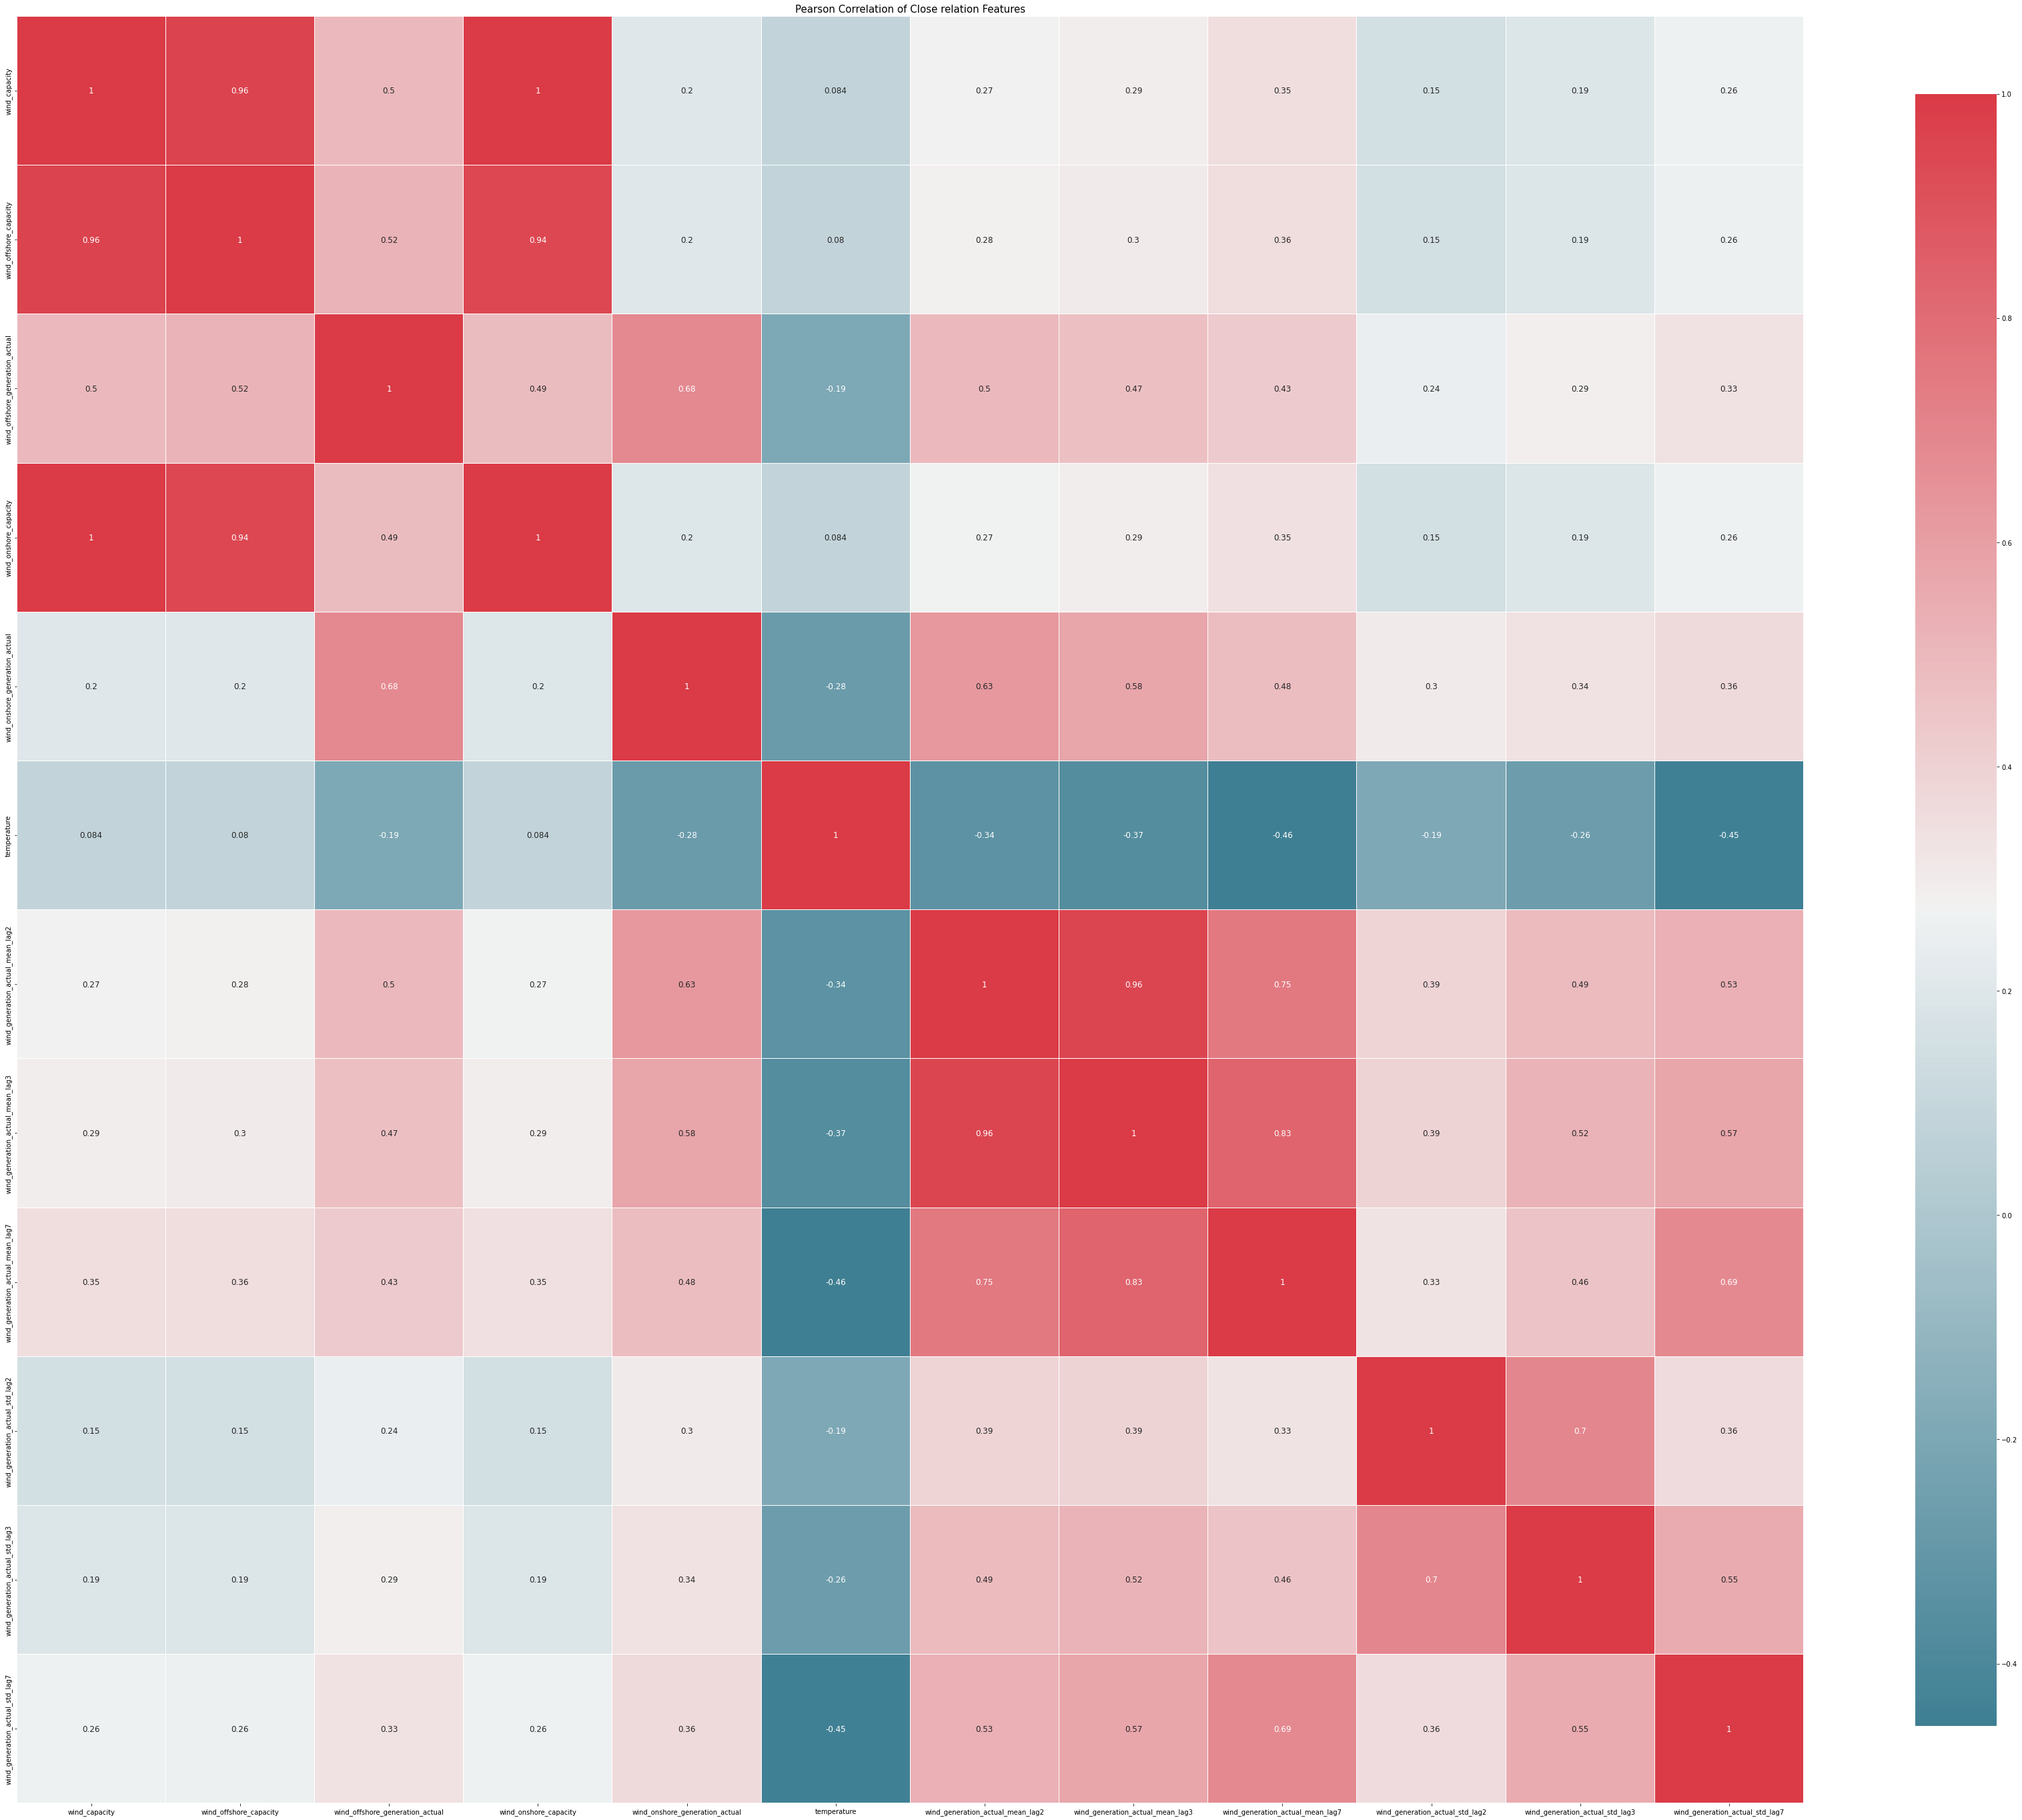

In [ ]:
data_x = data.copy()
data_x = data_x.drop(['wind_generation_actual',
       'utc_timestamp', 'year', 'month'],axis=1)


def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(60, 50))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)

    _ = sns.heatmap(
        df.corr(),
        cmap = colormap,
        square=True,
        cbar_kws={'shrink':.9 },
        ax=ax,
        annot=True,
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )

    plt.title('Pearson Correlation of Close relation Features', y=1.05, size=15)

correlation_heatmap(data_x)

split data into
train and test

# train being from 2017 to 2019 and test being from 2019 onwards

In [ ]:
train = data[data.year < 2019]
valid = data[data.year >= 2019]

 # can be done training using 2014-2018 and validation from 2018 (temprature data insufficiency
 )

In [ ]:
train.columns

Index(['utc_timestamp', 'wind_generation_actual', 'wind_capacity',
       'wind_offshore_capacity', 'wind_offshore_generation_actual',
       'wind_onshore_capacity', 'wind_onshore_generation_actual',
       'temperature', 'year', 'month', 'wind_generation_actual_mean_lag2',
       'wind_generation_actual_mean_lag3', 'wind_generation_actual_mean_lag7',
       'wind_generation_actual_std_lag2', 'wind_generation_actual_std_lag3',
       'wind_generation_actual_std_lag7'],
      dtype='object')

the adfuller test is used to determine if time series is stationary or not, here we see that it's stationary

In [ ]:
result = adfuller(data["wind_generation_actual"])
print("wind_generation_actual")
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

wind_generation_actual
ADF Statistic: -4.448569
p-value: 0.000243


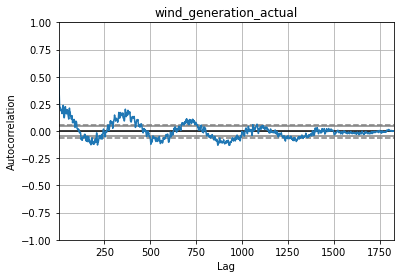

In [ ]:
# Autocorrelation graph
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data["wind_generation_actual"])
plt.title("wind_generation_actual")
plt.show()

Final Thoughts on Autocorrelation and Partial Autocorrelation

Identification of an AR model is often best done with the PACF.

For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model”  mean the most extreme lag of x that is used as a predictor.
Identification of an MA model is often best done with the ACF rather than the PACF.

For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.

p,d,q p AR model lags d differencing q MA lags

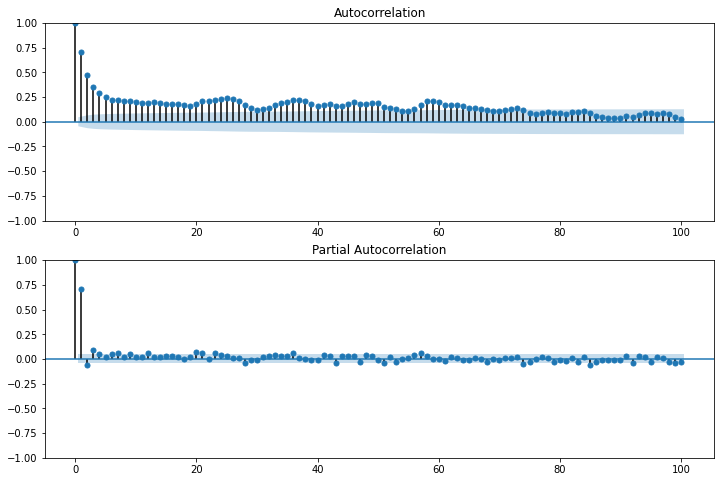

In [ ]:
#lets plot the graph to find the suitable value of P and Q
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data["wind_generation_actual"],lags=100,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data["wind_generation_actual"],lags=100,ax=ax2)
plt.show()

It gives us a p value which is exponential decrease till at what point=10,so (p=4)......
elect q value as 1 as there is suddent decrese in 1 (q=1)

# Fitting simple Arima Model

In [ ]:
# # p=4,d=0(as difference =0),q=1
from statsmodels.tsa.arima.model import ARIMA

 #lets fit our model

model=ARIMA(data["wind_generation_actual"],order=(4,0,1))
model_fit=model.fit()
print(model_fit.summary())



                                 SARIMAX Results                                  
Dep. Variable:     wind_generation_actual   No. Observations:                 1827
Model:                     ARIMA(4, 0, 1)   Log Likelihood              -24163.891
Date:                    Sat, 28 May 2022   AIC                          48341.781
Time:                            11:09:09   BIC                          48380.354
Sample:                                 0   HQIC                         48356.009
                                   - 1827                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.672e+05    5.2e-09   5.14e+13      0.000    2.67e+05    2.67e+05
ar.L1          1.6831      0.026     63.811      0.000       1.631       1.735
ar.L2         -0.822

# ARIMAX

In [ ]:
features = data_x.columns
arimaxmodel = auto_arima(train[features[1]],
                   exogenous = train[features], trace=True,
                   error_action="ignore", suppress_warnings=True)
arimaxmodel.fit(train['wind_generation_actual'], exogenous = train[features])
# model = arima()
arimaxforecast = arimaxmodel.predict(n_periods=len(valid), exogenous = valid[features])
valid["Forecast_ARIMAX"] = arimaxforecast


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-30898.865, Time=3.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-30906.442, Time=2.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-30904.640, Time=2.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-30904.898, Time=2.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-30908.442, Time=1.93 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-30921.069, Time=2.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-30900.255, Time=2.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-30900.640, Time=3.59 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-30902.980, Time=3.62 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-30902.662, Time=2.69 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-30922.679, Time=2.55 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-30906.892, Time=2.32 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-30906.638, Time=2.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-30902.308, Time=2.67 sec
 ARIM

In [ ]:
arimaxmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1462
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -9272.844
Date:                Sat, 28 May 2022   AIC                          18575.688
Time:                        11:10:03   BIC                          18654.992
Sample:                             0   HQIC                         18605.271
                               - 1462                                         
Covariance Type:                  opg                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
wind_capacity                      -13.2429     47.307     -0.280      0.780    -105.963      79.477
wind_offshore_capacity              12.8508     47.458      0.271      0.787     -80.164     105.866
wind_offshore_generation_actual      1.0002      0.001    833.653      0.000       0.998       1.003
wind_onshore_capacity               13.2947     47.285      0.281      0.779     -79.381     105.971
wind_onshore_generation_actual       1.0000      0.000   3803.869      0.000       0.999       1.001
temperature                          1.9463      9.466      0.206      0.837     -16.607      20.499
wind_generation_actual_mean_lag2    -0.0002      0.000     -0.508      0.612      -0.001       0.000
wind_generation_actual_mean_lag3     0.0002      0.000      0.350      0.726      -0.001       0.001
wind_generation_actual_mean_lag7  3.926e-06      0.001      0.006      0.995      -0.001       0.001
wind_generation_actual_std_lag2   3.213e-05      0.000      0.065      0.949      -0.001       0.001
wind_generation_actual_std_lag3     -0.0001      0.001     -0.236      0.814      -0.001       0.001
wind_generation_actual_std_lag7  -6.623e-05      0.001     -0.073      0.942      -0.002       0.002
ar.L1                                0.0083      0.018      0.455      0.649      -0.027       0.044
ma.L1                               -0.7487      0.015    -50.702      0.000      -0.778      -0.720
sigma2                             2.08e+04      1.709   1.22e+04      0.000    2.08e+04    2.08e+04
===================================================================================
Ljung-Box (L1) (Q):                  23.06   Jarque-Bera (JB):          71500618.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.80   Skew:                           -29.54
Prob(H) (two-sided):                  0.00   Kurtosis:                      1085.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+19. Standard errors may be unstable.
"""

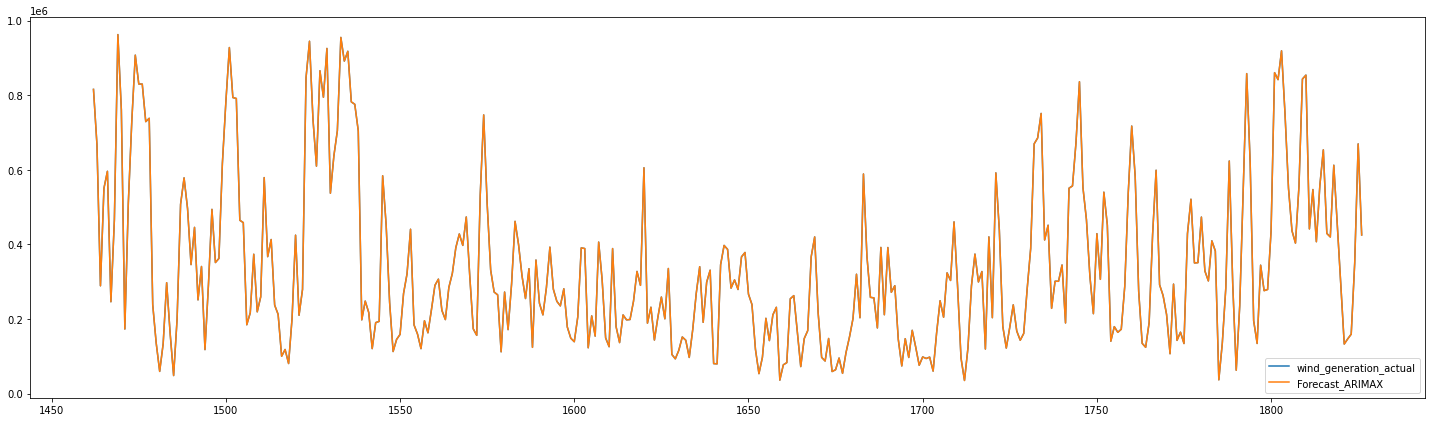

In [ ]:
#valid[["wind_generation_actual", "Forecast_ARIMAX"]].plot(figsize=(14, 7))
valid[["wind_generation_actual", "Forecast_ARIMAX"]].plot(figsize=(25, 7))
# plt.figure(figsize=(20,7))

# sns.lineplot(data=valid, x="utc_timestamp",y="wind_generation_actual")
# plt.xlabel("Time")
# plt.ylabel("wind generation actual")
# plt.title("The change wind by the years")


In [ ]:
arimax_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_ARIMAX))
arimax_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_ARIMAX)

print("RMSE of Auto ARIMAX:", arimax_rmse)
print("\nMAE of Auto ARIMAX:", arimax_mae)

RMSE of Auto ARIMAX: 125.89628382605815

MAE of Auto ARIMAX: 89.63226398956103


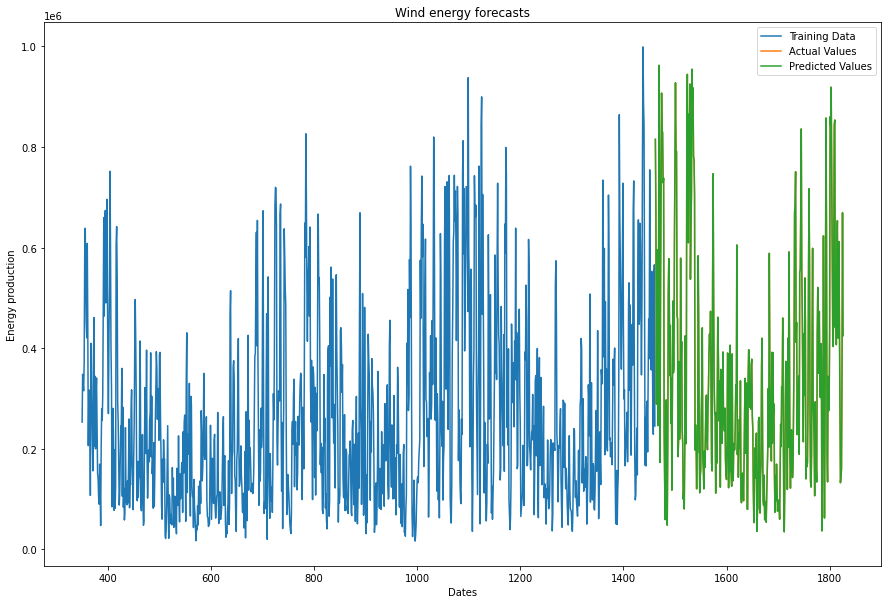

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, arimaxforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# Decision Trees

In [ ]:
dtregressor = DecisionTreeRegressor()
dtregressor.fit(train[features], train['wind_generation_actual'])
dtforecast = dtregressor.predict(valid[features])
valid["Forecast_DT"] = dtforecast

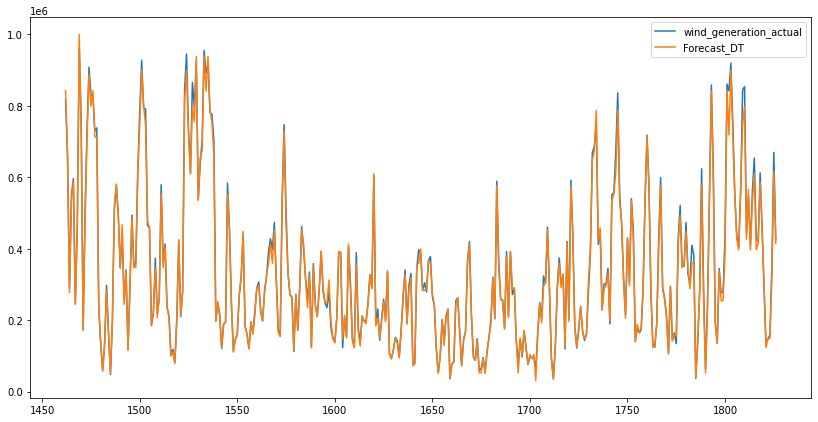

In [ ]:
valid[["wind_generation_actual", "Forecast_DT"]].plot(figsize=(14, 7))

# ax.set(xlabel='x axis', ylabel='y axis')
# plt.show()

# valid.plot(xlabel='X Label', ylabel='Y Label', title='Plot Title')

In [ ]:
dt_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_DT))
dt_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_DT)

print("RMSE of Decision Trees:", dt_rmse)
print("\nMAE of Decision Trees:", dt_mae)

RMSE of Decision Trees: 18245.90219042253

MAE of Decision Trees: 11362.397260273972


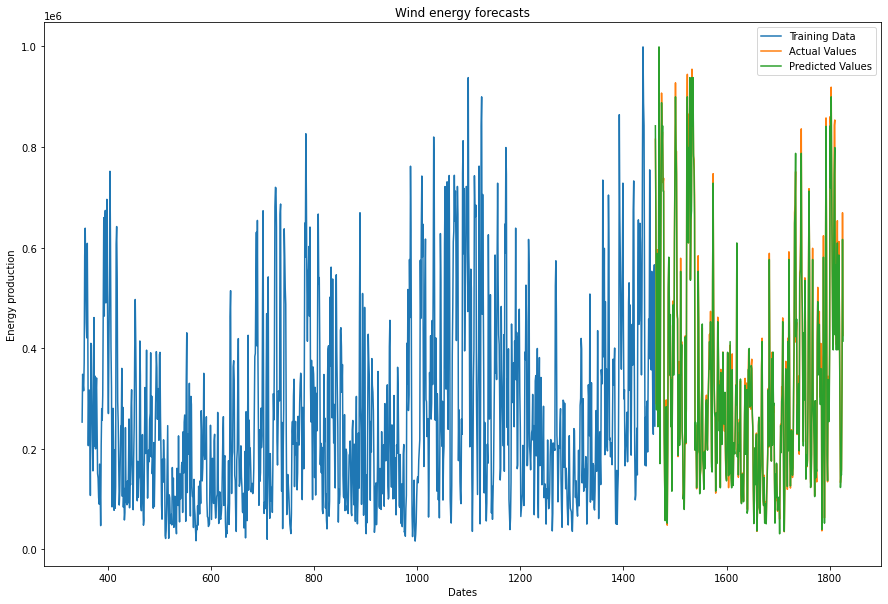

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, dtforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

In [ ]:
# # using interactive graph - plotly
# px.scatter_3d(valid, x="utc_timestamp",y="wind_generation_actual",z="Forecast_ARIMAX")

# Random Forest

In [ ]:
rfregressor = RandomForestRegressor()
rfregressor.fit(train[features], train['wind_generation_actual'])
rfforecast = rfregressor.predict(valid[features])
valid["Forecast_RF"] = rfforecast

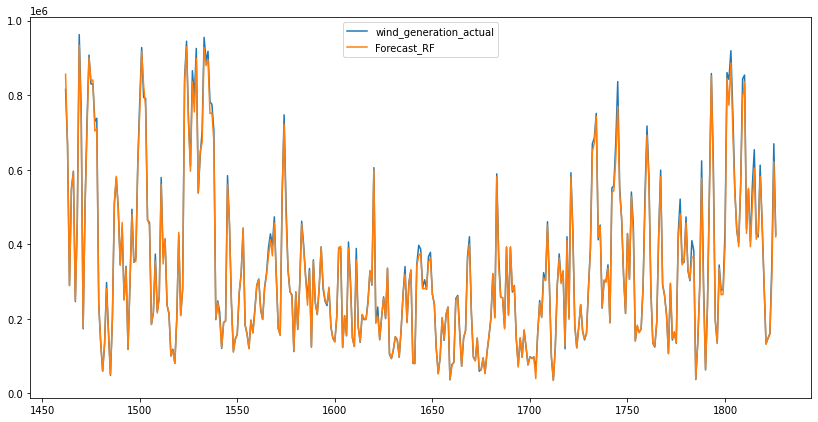

In [ ]:
valid[["wind_generation_actual", "Forecast_RF"]].plot(figsize=(14, 7))

In [ ]:
rf_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_RF))
rf_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_RF)

print("RMSE of Random Forests:", rf_rmse)
print("\nMAE of Random Forests:", rf_mae)

RMSE of Random Forests: 14232.520149815187

MAE of Random Forests: 8319.94115068493


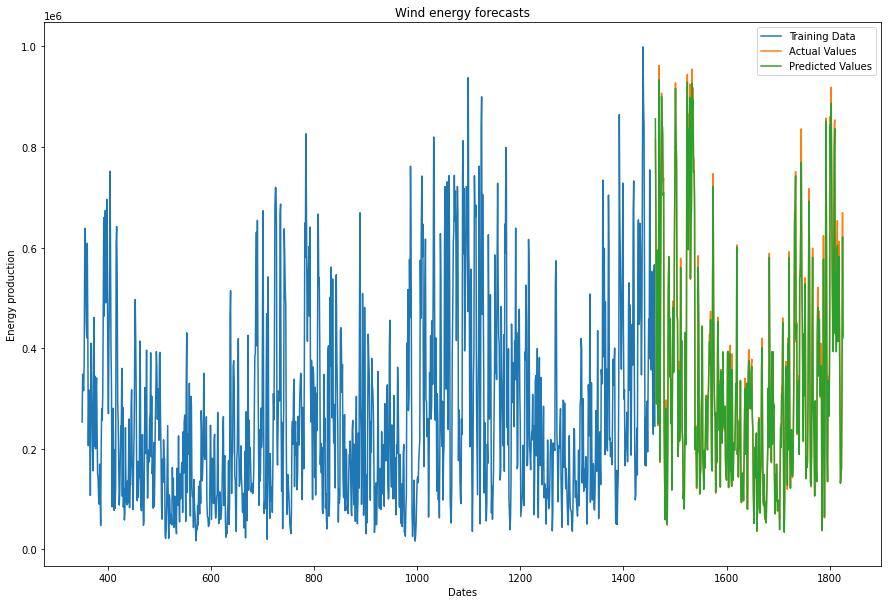

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, rfforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# Support Vector Machine

In [ ]:
svmregressor = SVR()
svmregressor.fit(train[features], train['wind_generation_actual'])
svmforecast = svmregressor.predict(valid[features])
valid["Forecast_SVM"] = svmforecast

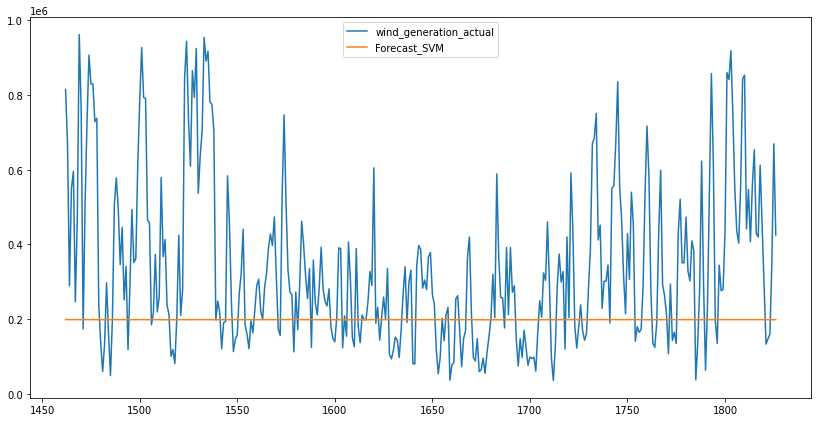

In [ ]:
valid[["wind_generation_actual", "Forecast_SVM"]].plot(figsize=(14, 7))

In [ ]:
svm_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_SVM))
svm_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_SVM)

print("RMSE of SVM:", svm_rmse)
print("\nMAE of SVM:", svm_mae)

RMSE of SVM: 260662.38047897827

MAE of SVM: 182642.80270520566


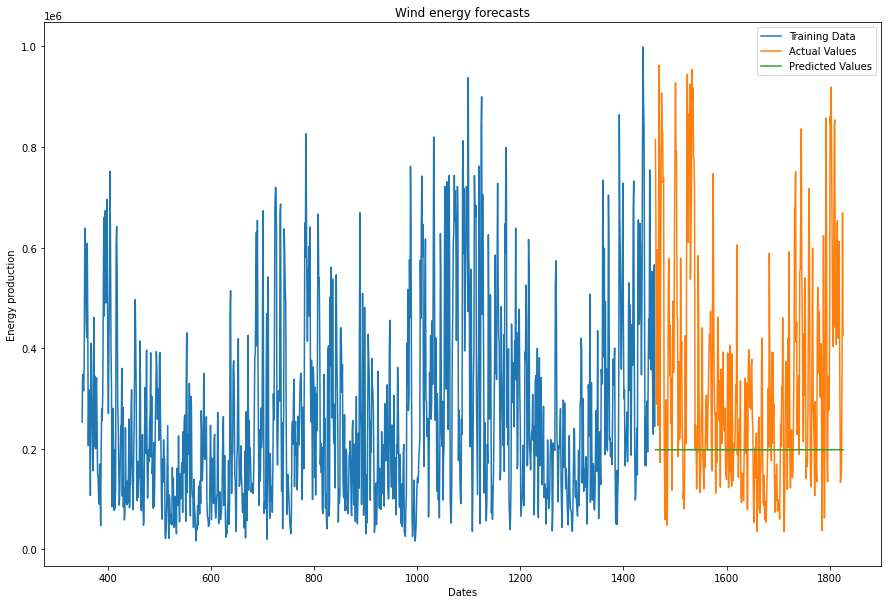

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, svmforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# Artificial Neural Network

In [ ]:
X_train, X_valid, Y_train, Y_valid=train[features], valid[features], train["wind_generation_actual"], valid["wind_generation_actual"]
X_train, X_valid = np.array(X_train), np.array(X_valid)

X_train_array = np.asarray(X_train.reshape((X_train.shape[0], 1, X_train.shape[1])))
X_valid_array = np.asarray(X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1]))
Y_train_array = np.asarray(Y_train)
Y_valid_array = np.asarray(Y_valid)

In [ ]:
X_train.shape

(1462, 12)

In [ ]:
X_valid_array.shape

(365, 1, 12)

In [ ]:
ann_model = Sequential([
    Dense(32, activation="relu", input_shape=(1, X_train_array.shape[2])),
    Dense(8, activation="relu"),
    Dense(1)
    ])

In [ ]:
ann_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = ann_model.fit(X_train_array, Y_train_array,
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=1, batch_size = 128)

Epoch 1/150
12/12 [==============================] - 4s 27ms/step - loss: 99721543680.0000 - root_mean_squared_error: 316499.8750 - val_loss: 155367948288.0000 - val_root_mean_squared_error: 392186.4688
Epoch 2/150
12/12 [==============================] - 0s 7ms/step - loss: 86107709440.0000 - root_mean_squared_error: 294795.8750 - val_loss: 133759270912.0000 - val_root_mean_squared_error: 363956.0938
Epoch 3/150
12/12 [==============================] - 0s 6ms/step - loss: 76877086720.0000 - root_mean_squared_error: 277065.0312 - val_loss: 118090039296.0000 - val_root_mean_squared_error: 342034.8438
Epoch 4/150
12/12 [==============================] - 0s 7ms/step - loss: 69816311808.0000 - root_mean_squared_error: 264500.2812 - val_loss: 104119402496.0000 - val_root_mean_squared_error: 321218.0312
Epoch 5/150
12/12 [==============================] - 0s 7ms/step - loss: 62993469440.0000 - root_mean_squared_error: 250964.7656 - val_loss: 90053795840.0000 - val_root_mean_squared_error: 29

In [ ]:
annforecast = ann_model.predict(X_valid_array)
valid["Forecast_ANN"] = annforecast.squeeze()

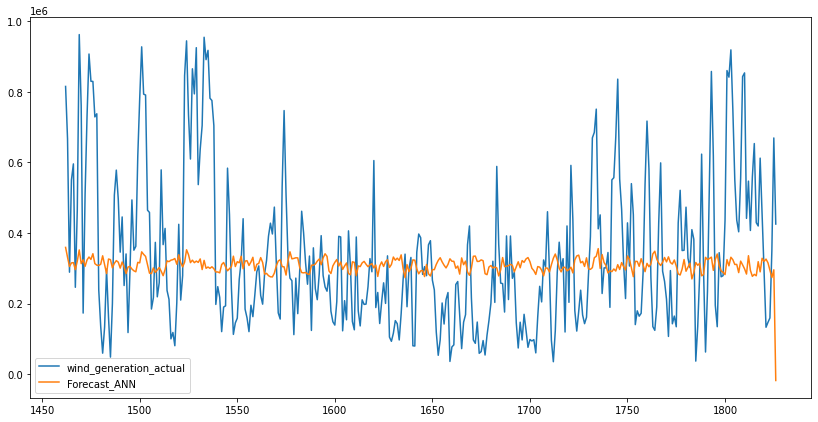

In [ ]:
valid[["wind_generation_actual", "Forecast_ANN"]].plot(figsize=(14, 7))

In [ ]:
ann_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_ANN))
ann_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_ANN)

print("RMSE of ANN:", ann_rmse)
print("\nMAE of ANN:", ann_mae)

RMSE of ANN: 223524.06744703834

MAE of ANN: 174240.3268568065


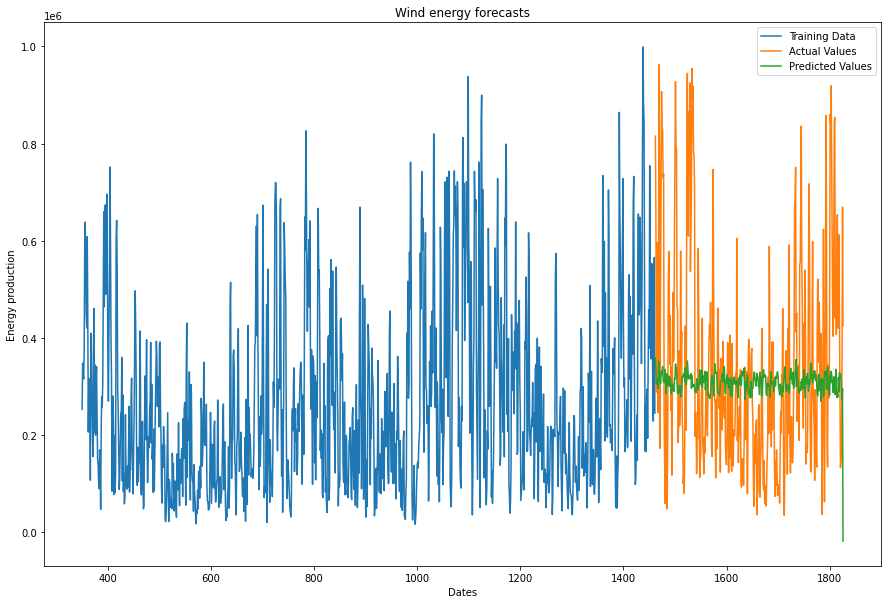

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, annforecast.squeeze(), label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# Recurrent Neural Network

In [ ]:
rnn_model = Sequential([
    SimpleRNN(50, activation = "relu", return_sequences=False, input_shape=(1, X_train_array.shape[2])),
    Dense(8, activation="relu"),
    Dense(1)

    ])
rnn_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = rnn_model.fit(X_train_array, Y_train_array,
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=2, batch_size = 128)

Epoch 1/150
12/12 - 2s - loss: 174333640704.0000 - root_mean_squared_error: 417532.7812 - val_loss: 238933458944.0000 - val_root_mean_squared_error: 488808.1562 - 2s/epoch - 129ms/step
Epoch 2/150
12/12 - 0s - loss: 113944174592.0000 - root_mean_squared_error: 337556.1875 - val_loss: 146926485504.0000 - val_root_mean_squared_error: 383309.9062 - 70ms/epoch - 6ms/step
Epoch 3/150
12/12 - 0s - loss: 71429922816.0000 - root_mean_squared_error: 267263.7500 - val_loss: 98827968512.0000 - val_root_mean_squared_error: 314369.1562 - 74ms/epoch - 6ms/step
Epoch 4/150
12/12 - 0s - loss: 42796806144.0000 - root_mean_squared_error: 206873.8906 - val_loss: 39097257984.0000 - val_root_mean_squared_error: 197730.2656 - 70ms/epoch - 6ms/step
Epoch 5/150
12/12 - 0s - loss: 14738229248.0000 - root_mean_squared_error: 121401.1094 - val_loss: 12860473344.0000 - val_root_mean_squared_error: 113404.0234 - 74ms/epoch - 6ms/step
Epoch 6/150
12/12 - 0s - loss: 8882609152.0000 - root_mean_squared_error: 94247.5

In [ ]:
rnnforecast = rnn_model.predict(X_valid_array)
valid["Forecast_RNN"] = rnnforecast

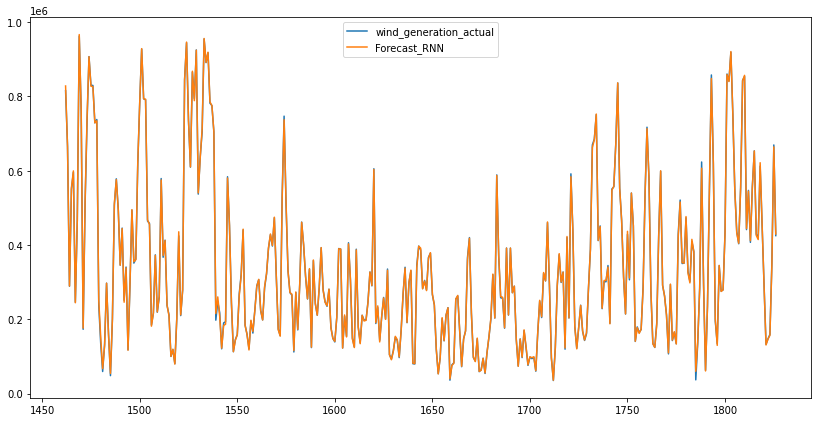

In [ ]:
valid[["wind_generation_actual", "Forecast_RNN"]].plot(figsize=(14, 7))

In [ ]:
rnn_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_RNN))
rnn_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_RNN)

print("RMSE of RNN:", rnn_rmse)
print("\nMAE of RNN:", rnn_mae)

RMSE of RNN: 3753.8314294020156

MAE of RNN: 2474.8786172945206


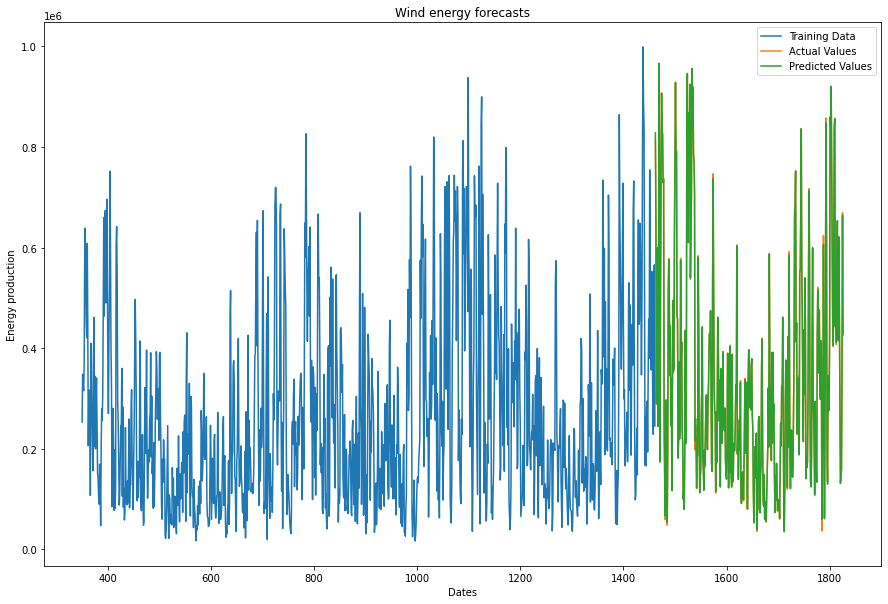

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, rnnforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# LSTM

In [ ]:
lstm_model = Sequential([
    Bidirectional(LSTM(100, activation = "relu", return_sequences=False, input_shape=(1, X_train_array.shape[2]))),
    Dense(8, activation="relu"),
    Dense(1)

    ])
lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate = 0.001),
                metrics=[tf.metrics.RootMeanSquaredError()])

In [ ]:
history = lstm_model.fit(X_train_array, Y_train_array,
     validation_data=(X_valid_array, Y_valid_array),
     epochs=150, verbose=2, batch_size = 128)

Epoch 1/150
12/12 - 3s - loss: 91364728832.0000 - root_mean_squared_error: 302265.9688 - val_loss: 120829902848.0000 - val_root_mean_squared_error: 347605.9688 - 3s/epoch - 290ms/step
Epoch 2/150
12/12 - 0s - loss: 58682073088.0000 - root_mean_squared_error: 242243.8281 - val_loss: 68819648512.0000 - val_root_mean_squared_error: 262334.9688 - 129ms/epoch - 11ms/step
Epoch 3/150
12/12 - 0s - loss: 32635609088.0000 - root_mean_squared_error: 180653.2812 - val_loss: 32642717696.0000 - val_root_mean_squared_error: 180672.9531 - 131ms/epoch - 11ms/step
Epoch 4/150
12/12 - 0s - loss: 18944907264.0000 - root_mean_squared_error: 137640.5000 - val_loss: 21834627072.0000 - val_root_mean_squared_error: 147765.4375 - 133ms/epoch - 11ms/step
Epoch 5/150
12/12 - 0s - loss: 13458613248.0000 - root_mean_squared_error: 116011.2656 - val_loss: 14608304128.0000 - val_root_mean_squared_error: 120864.8203 - 129ms/epoch - 11ms/step
Epoch 6/150
12/12 - 0s - loss: 8921489408.0000 - root_mean_squared_error: 94

In [ ]:
lstmforecast = lstm_model.predict(X_valid_array)
valid["Forecast_LSTM"] = lstmforecast

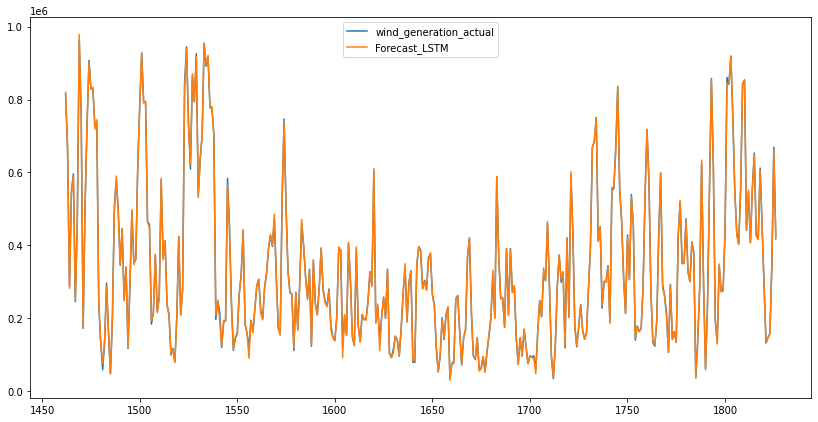

In [ ]:
valid[["wind_generation_actual", "Forecast_LSTM"]].plot(figsize=(14, 7))

In [ ]:
lstm_rmse = np.sqrt(mean_squared_error(valid["wind_generation_actual"], valid.Forecast_LSTM))
lstm_mae = mean_absolute_error(valid["wind_generation_actual"], valid.Forecast_LSTM)

print("RMSE of LSTM:", lstm_rmse)
print("\nMAE of LSTM:", lstm_mae)

RMSE of LSTM: 5627.240385170262

MAE of LSTM: 3802.8861729452055


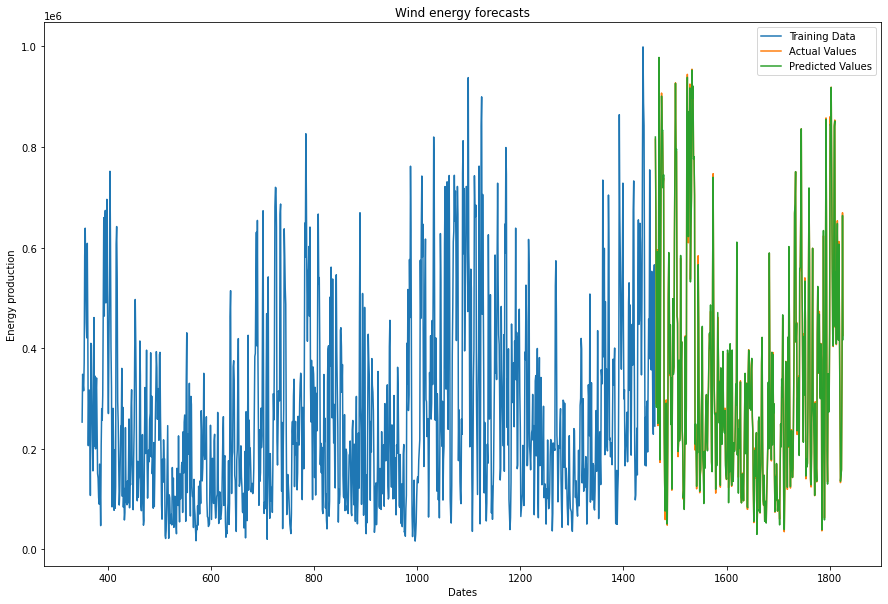

In [ ]:
fig, axes = plt.subplots(figsize=(15, 10))

axes.plot(train.iloc[350:,:]["wind_generation_actual"], label='Training Data')
axes.plot(valid.index, valid["wind_generation_actual"], label='Actual Values')
axes.plot(valid.index, lstmforecast,label='Predicted Values')
axes.set_title('Wind energy forecasts')
axes.set_xlabel('Dates')
axes.set_ylabel('Energy production')
axes.legend()

# Conclusion

In [ ]:

metrics = {'Models' : ['ARIMAX', 'Decision Trees', 'Random Forest', 'SVM', 'ANN', 'RNN', 'LSTM'],
           'RMSE'   : [arimax_rmse, dt_rmse, rf_rmse, svm_rmse, ann_rmse, rnn_rmse, lstm_rmse],
           'MAE'    : [arimax_mae, dt_mae, rf_mae, svm_mae, ann_mae, rnn_mae, lstm_mae],
           'NRMSE'  : [arimax_rmse/valid.Forecast_ARIMAX.mean(), dt_rmse/valid.Forecast_DT.mean(),
                       rf_rmse/valid.Forecast_RF.mean(), svm_rmse/valid.Forecast_SVM.mean(),
                       ann_rmse/valid.Forecast_ANN.mean(), rnn_rmse/valid.Forecast_RNN.mean(),
                       lstm_rmse/valid.Forecast_LSTM.mean()]}
metrics = pd.DataFrame(metrics)

In [ ]:
metrics.sort_values(by = 'RMSE')

,Models,RMSE,MAE,NRMSE
0,ARIMAX,125.896284,89.632264,0.000371
5,RNN,3753.831429,2474.878617,0.011055
6,LSTM,5627.240385,3802.886173,0.016613
2,Random Forest,14232.520150,8319.941151,0.042711
1,Decision Trees,18245.902190,11362.397260,0.054902
4,ANN,223524.067447,174240.326857,0.725219
3,SVM,260662.380479,182642.802705,1.316195


In [ ]:
metrics.sort_values(by = 'MAE')

,Models,RMSE,MAE,NRMSE
0,ARIMAX,125.896284,89.632264,0.000371
5,RNN,3753.831429,2474.878617,0.011055
6,LSTM,5627.240385,3802.886173,0.016613
2,Random Forest,14232.520150,8319.941151,0.042711
1,Decision Trees,18245.902190,11362.397260,0.054902
4,ANN,223524.067447,174240.326857,0.725219
3,SVM,260662.380479,182642.802705,1.316195
